In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 로드
df_merged = pd.read_csv('df_merged.csv')

### 생장 주기에 대한 이론과 데이터 검증

In [3]:
# 월별 주요 지표 계산
monthly_stats = df_merged.groupby('month').agg({
    'PI_abs': ['mean', 'std'],
    'Fv-Fm': ['mean', 'std'],
    'TChl': ['mean', 'std'],
    'Leaf_TPC': 'mean',
    'Root_TPC': 'mean'
}).round(3)

In [4]:
# Source-Sink 비율 계산
monthly_stats['Source_Sink_Ratio'] = (monthly_stats['Leaf_TPC']['mean'] / 
                                       monthly_stats['Root_TPC']['mean']).round(2)

In [5]:
print(monthly_stats)

      PI_abs         Fv-Fm           TChl        Leaf_TPC Root_TPC  \
        mean    std   mean    std    mean    std     mean     mean   
month                                                                
5      2.510  0.771  0.836  0.006  10.756  2.378    7.405    6.354   
6      2.196  1.025  0.824  0.012   6.749  1.440    8.124    5.189   
7      1.864  0.484  0.821  0.008   6.789  1.597    7.951    5.252   
8      1.458  0.442  0.808  0.006   7.113  1.892    7.682    4.639   
9      0.401  0.286  0.713  0.053   5.739  2.160    7.186    4.903   

      Source_Sink_Ratio  
                         
month                    
5                  1.17  
6                  1.57  
7                  1.51  
8                  1.66  
9                  1.47  


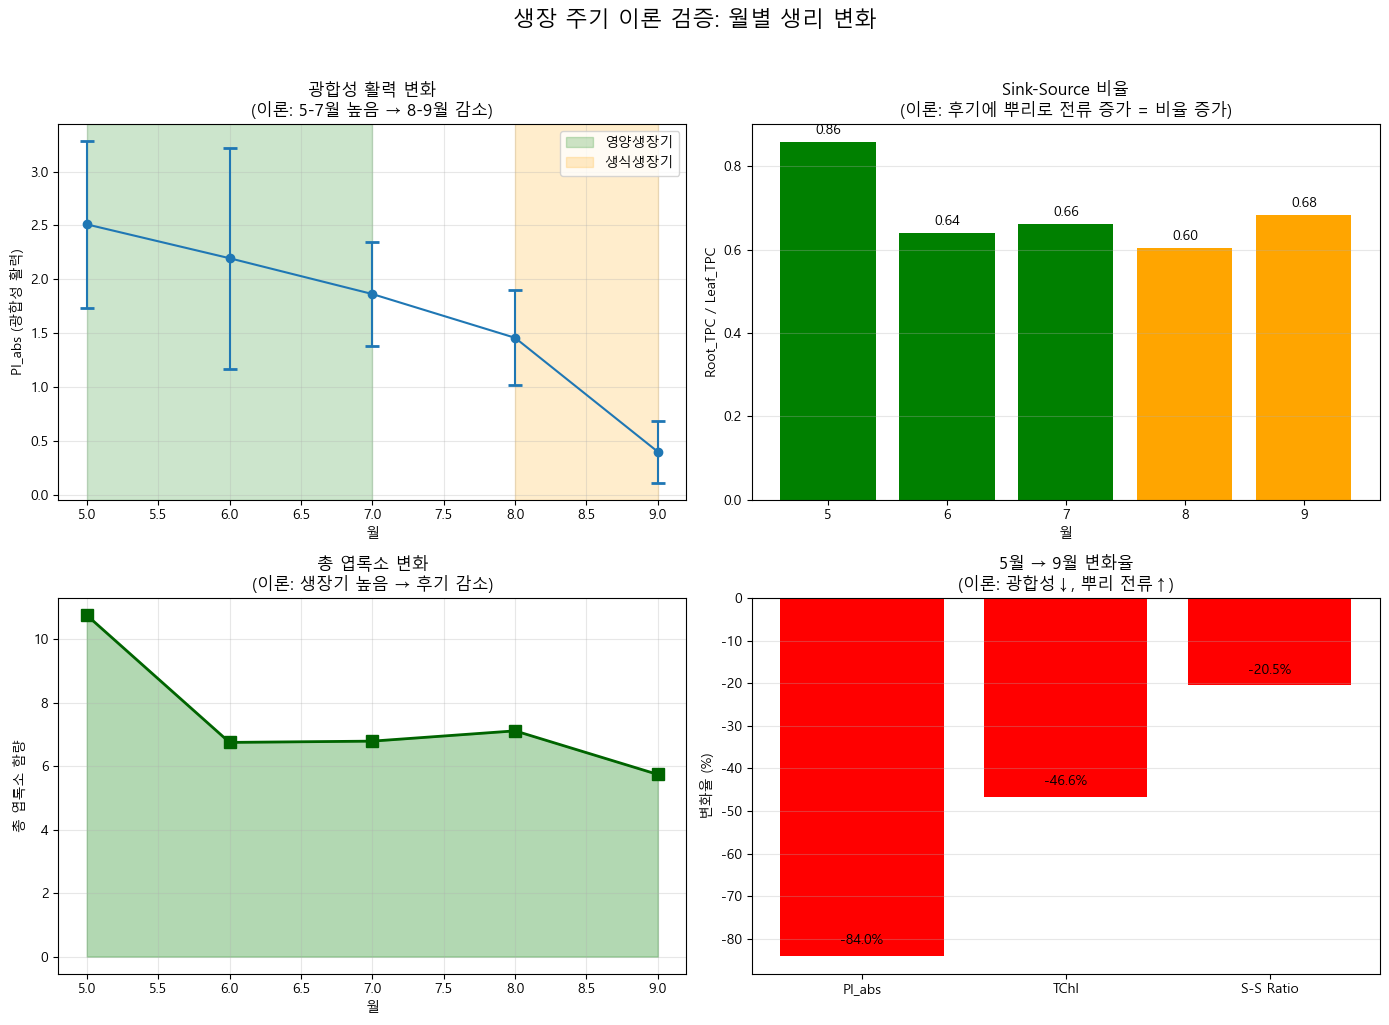

In [10]:
# 수정된 시각화: 생장 주기별 변화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('생장 주기 이론 검증: 월별 생리 변화', fontsize=16, y=1.02)

# 안전한 데이터 추출 함수
def safe_extract_data(monthly_stats, months, column_tuple, default_value=0):
    """MultiIndex DataFrame에서 안전하게 데이터 추출"""
    try:
        if isinstance(column_tuple, tuple):
            return [monthly_stats.loc[m, column_tuple] if not pd.isna(monthly_stats.loc[m, column_tuple]) 
                   else default_value for m in months]
        else:
            return [monthly_stats.loc[m, column_tuple] if not pd.isna(monthly_stats.loc[m, column_tuple]) 
                   else default_value for m in months]
    except KeyError as e:
        print(f"컬럼 {column_tuple}에 접근할 수 없습니다: {e}")
        return [default_value] * len(months)

# 월 목록 생성
months = sorted(df_merged['month'].unique())

# 1. PI_abs 변화 (수정됨)
ax1 = axes[0, 0]
try:
    pi_means = safe_extract_data(monthly_stats, months, ('PI_abs', 'mean'))
    pi_stds = safe_extract_data(monthly_stats, months, ('PI_abs', 'std'))
    
    ax1.errorbar(months, pi_means, yerr=pi_stds, marker='o', capsize=5, capthick=2) #errorbar 선 그래프프
    ax1.set_xlabel('월')
    ax1.set_ylabel('PI_abs (광합성 활력)')
    ax1.set_title('광합성 활력 변화\n(이론: 5-7월 높음 → 8-9월 감소)')
    ax1.grid(True, alpha=0.3)
    ax1.axvspan(5, 7, alpha=0.2, color='green', label='영양생장기')
    ax1.axvspan(8, 9, alpha=0.2, color='orange', label='생식생장기')
    ax1.legend()
except Exception as e:
    print(f"PI_abs 그래프 오류: {e}")

# 2. Source-Sink 비율 (수정됨) - 올바른 공식
ax2 = axes[0, 1]
try:
    ss_ratio = []
    for m in months:
        leaf_val = monthly_stats.loc[m, ('Leaf_TPC', 'mean')] if ('Leaf_TPC', 'mean') in monthly_stats.columns else monthly_stats.loc[m, 'Leaf_TPC']
        root_val = monthly_stats.loc[m, ('Root_TPC', 'mean')] if ('Root_TPC', 'mean') in monthly_stats.columns else monthly_stats.loc[m, 'Root_TPC']
        
        # 수정된 계산 - 방법 1: Root/Leaf 비율
        ss_ratio.append(float(root_val) / float(leaf_val))
        
        # 또는 방법 2: 뿌리 비중
        # ss_ratio.append(float(root_val) / (float(leaf_val) + float(root_val)))
    
    bars = ax2.bar(months, ss_ratio, color=['green' if m <= 7 else 'orange' for m in months])
    ax2.set_xlabel('월')
    ax2.set_ylabel('Root_TPC / Leaf_TPC')  # 수정된 라벨
    ax2.set_title('Sink-Source 비율\n(이론: 후기에 뿌리로 전류 증가 = 비율 증가)')  # 수정된 제목
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(ss_ratio):
        ax2.text(months[i], v + 0.02, f'{v:.2f}', ha='center')
        
except Exception as e:
    print(f"Source-Sink 비율 그래프 오류: {e}")

# 3. 엽록소 함량 변화 (수정됨)
ax3 = axes[1, 0]
try:
    tchl_means = safe_extract_data(monthly_stats, months, ('TChl', 'mean'))
    
    ax3.plot(months, tchl_means, marker='s', markersize=8, linewidth=2, color='darkgreen')
    ax3.set_xlabel('월')
    ax3.set_ylabel('총 엽록소 함량')
    ax3.set_title('총 엽록소 변화\n(이론: 생장기 높음 → 후기 감소)')
    ax3.grid(True, alpha=0.3)
    ax3.fill_between(months, tchl_means, alpha=0.3, color='green')
    
except Exception as e:
    print(f"엽록소 그래프 오류: {e}")

# 4. 변화율 요약 (수정됨)
ax4 = axes[1, 1]
try:
    if 5 in months and 9 in months:
        may_idx = months.index(5)
        sep_idx = months.index(9)
        
        # 안전한 변화율 계산
        pi_change = ((pi_means[sep_idx] - pi_means[may_idx]) / pi_means[may_idx] * 100) if pi_means[may_idx] != 0 else 0 # (9월값 - 5월값) / 5월값 x 100
        tchl_change = ((tchl_means[sep_idx] - tchl_means[may_idx]) / tchl_means[may_idx] * 100) if tchl_means[may_idx] != 0 else 0
        ss_change = ((ss_ratio[sep_idx] - ss_ratio[may_idx]) / ss_ratio[may_idx] * 100) if ss_ratio[may_idx] != 0 else 0
        
        changes = {
            'PI_abs': pi_change,
            'TChl': tchl_change,
            'S-S Ratio': ss_change
        }
        
        colors = ['red' if v < 0 else 'blue' for v in changes.values()]
        bars = ax4.bar(changes.keys(), changes.values(), color=colors)
        ax4.set_ylabel('변화율 (%)')
        ax4.set_title('5월 → 9월 변화율\n(이론: 광합성↓, 뿌리 전류↑)')
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax4.grid(True, alpha=0.3, axis='y')
        
        for bar, value in zip(bars, changes.values()):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{value:.1f}%', ha='center', va='bottom')
                    
except Exception as e:
    print(f"변화율 그래프 오류: {e}")

plt.tight_layout()
plt.show()

- Source-Sink 비율에서 뿌리로 전류 증가 시 뿌리 저장 효율이 늘어나는 것인데 별 차이 없어 보임.
- -> 온도, 습도, 토양 조건 등 다양한 방법으로 EDA 해서 확인해봐야 명확히 보일듯.
- 총 엽록소 변화 감소 = 광합성 감소를 보여줌
- -> PI_abs 급감 = 천궁 자연적 생리현상으로 취급해야함.
- 뿌리 전류 많이 증가 한 거로 보임.

### 시나리오별 스트레스 반응 메커니즘 확인
- CO2 농도 증가 따른 광합성 시스템 반응 확인

In [11]:
# 시나리오별 통계
scenario_stats = df_merged.groupby('scenario').agg({
    'CO2ppm': 'mean',
    'Temp': 'mean',
    'Fv-Fm': 'mean',
    'PI_abs': 'mean',
    'TChl': 'mean',
    'Dio-RC': 'mean',
    'ABS-RC': 'mean',
    'Leaf_TPC': 'mean',
    'Root_TPC': 'mean'
}).round(3)

In [13]:
# 열소산 비율 계산
scenario_stats['Dissipation_Ratio'] = (scenario_stats['Dio-RC'] / 
                                        scenario_stats['ABS-RC'] * 100).round(1)

print(scenario_stats)

            CO2ppm    Temp  Fv-Fm  PI_abs   TChl  Dio-RC  ABS-RC  Leaf_TPC  \
scenario                                                                     
SSP1       427.826  22.859  0.815   2.198  8.832   0.355   1.854     7.482   
SSP3       918.367  24.657  0.790   1.413  6.772   0.495   2.227     7.801   
SSP5      1173.970  25.465  0.789   1.228  5.628   0.528   2.377     7.842   

          Root_TPC  Dissipation_Ratio  
scenario                               
SSP1         5.114               19.1  
SSP3         5.154               22.2  
SSP5         5.174               22.2  


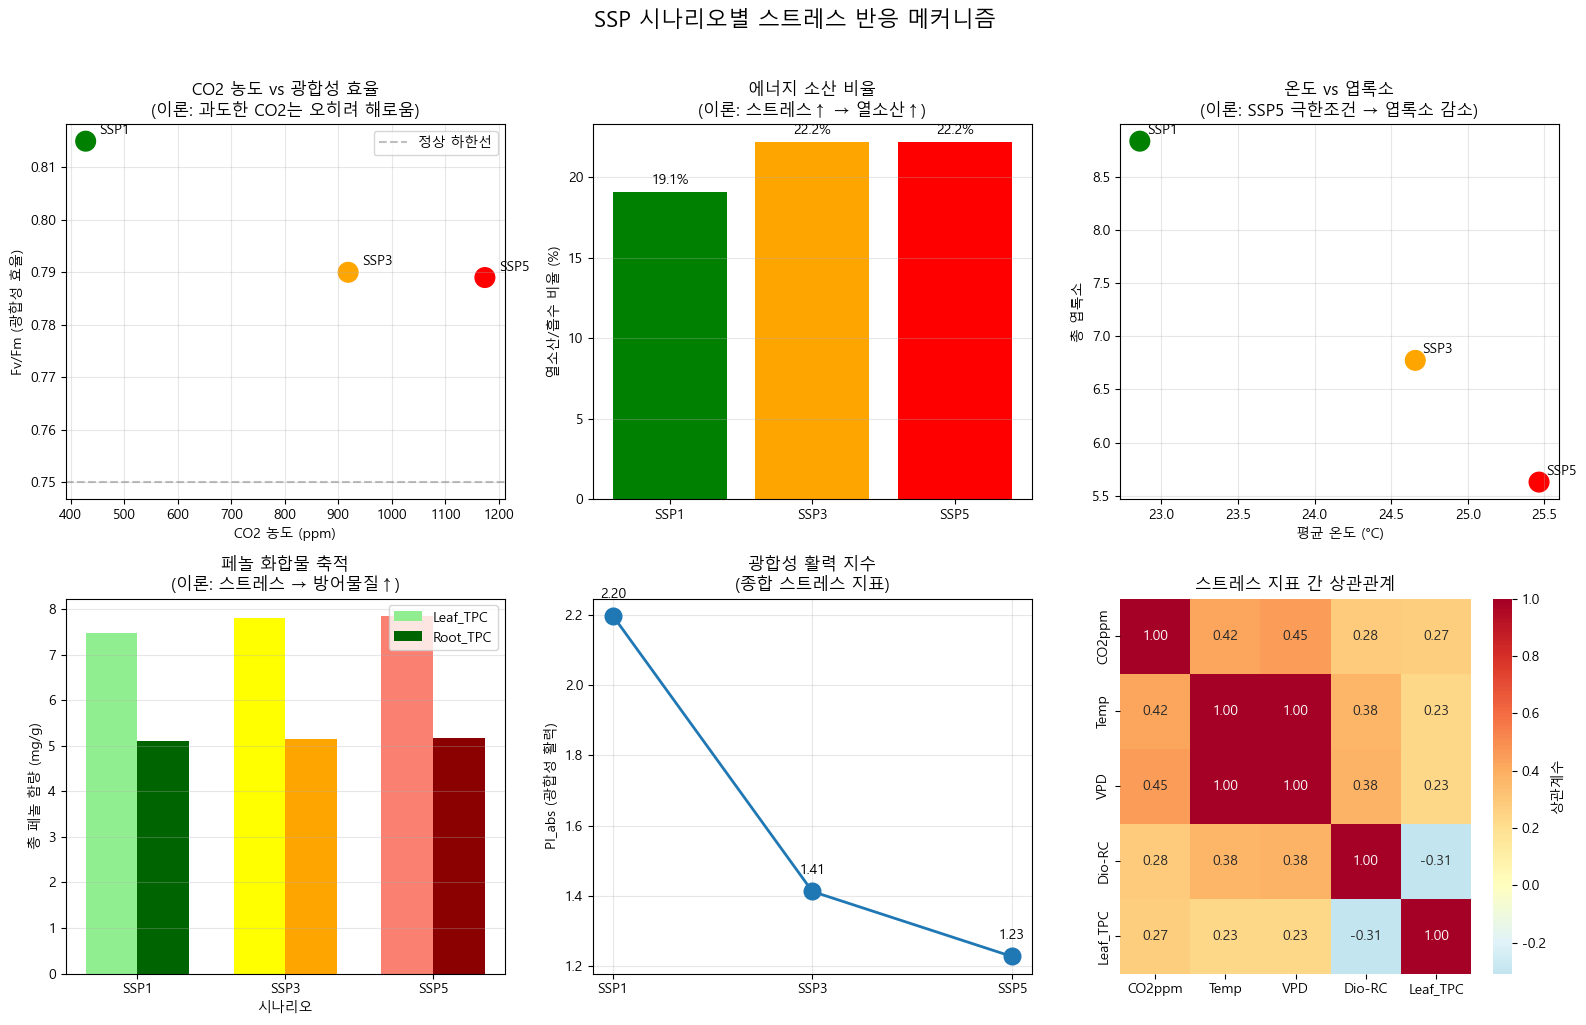

In [14]:
# 시각화: SSP 시나리오 비교
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('SSP 시나리오별 스트레스 반응 메커니즘', fontsize=16, y=1.02)

scenarios = ['SSP1', 'SSP3', 'SSP5']
colors_ssp = {'SSP1': 'green', 'SSP3': 'orange', 'SSP5': 'red'}

# 1. CO2 농도 vs 광합성 효율
ax1 = axes[0, 0]
co2_values = [scenario_stats.loc[s, 'CO2ppm'] for s in scenarios]
fv_fm_values = [scenario_stats.loc[s, 'Fv-Fm'] for s in scenarios]
ax1.scatter(co2_values, fv_fm_values, s=200, c=[colors_ssp[s] for s in scenarios])
for i, s in enumerate(scenarios):
    ax1.annotate(s, (co2_values[i], fv_fm_values[i]), 
                xytext=(10, 5), textcoords='offset points')
ax1.set_xlabel('CO2 농도 (ppm)')
ax1.set_ylabel('Fv/Fm (광합성 효율)')
ax1.set_title('CO2 농도 vs 광합성 효율\n(이론: 과도한 CO2는 오히려 해로움)')
ax1.axhline(y=0.75, color='gray', linestyle='--', alpha=0.5, label='정상 하한선')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. 열소산 비율
ax2 = axes[0, 1]
dissipation = [scenario_stats.loc[s, 'Dissipation_Ratio'] for s in scenarios]
bars = ax2.bar(scenarios, dissipation, color=[colors_ssp[s] for s in scenarios])
ax2.set_ylabel('열소산/흡수 비율 (%)')
ax2.set_title('에너지 소산 비율\n(이론: 스트레스↑ → 열소산↑)')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, dissipation):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.5,
            f'{val:.1f}%', ha='center')

# 3. 엽록소 vs 스트레스
ax3 = axes[0, 2]
tchl_values = [scenario_stats.loc[s, 'TChl'] for s in scenarios]
temp_values = [scenario_stats.loc[s, 'Temp'] for s in scenarios]
scatter = ax3.scatter(temp_values, tchl_values, s=200,
                     c=[colors_ssp[s] for s in scenarios])
for i, s in enumerate(scenarios):
    ax3.annotate(s, (temp_values[i], tchl_values[i]),
                xytext=(5, 5), textcoords='offset points')
ax3.set_xlabel('평균 온도 (°C)')
ax3.set_ylabel('총 엽록소')
ax3.set_title('온도 vs 엽록소\n(이론: SSP5 극한조건 → 엽록소 감소)')
ax3.grid(True, alpha=0.3)

# 4. 페놀 화합물 반응
ax4 = axes[1, 0]
leaf_tpc = [scenario_stats.loc[s, 'Leaf_TPC'] for s in scenarios]
root_tpc = [scenario_stats.loc[s, 'Root_TPC'] for s in scenarios]
x = np.arange(len(scenarios))
width = 0.35
bars1 = ax4.bar(x - width/2, leaf_tpc, width, label='Leaf_TPC',
               color=['lightgreen', 'yellow', 'salmon'])
bars2 = ax4.bar(x + width/2, root_tpc, width, label='Root_TPC',
               color=['darkgreen', 'orange', 'darkred'])
ax4.set_xlabel('시나리오')
ax4.set_ylabel('총 페놀 함량 (mg/g)')
ax4.set_title('페놀 화합물 축적\n(이론: 스트레스 → 방어물질↑)')
ax4.set_xticks(x)
ax4.set_xticklabels(scenarios)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. PI_abs 변화
ax5 = axes[1, 1]
pi_values = [scenario_stats.loc[s, 'PI_abs'] for s in scenarios]
ax5.plot(scenarios, pi_values, marker='o', markersize=12, linewidth=2)
ax5.set_ylabel('PI_abs (광합성 활력)')
ax5.set_title('광합성 활력 지수\n(종합 스트레스 지표)')
ax5.grid(True, alpha=0.3)
for i, val in enumerate(pi_values):
    ax5.text(i, val + 0.05, f'{val:.2f}', ha='center')

# 6. 스트레스 지표 상관 매트릭스
ax6 = axes[1, 2]
stress_indicators = df_merged[['CO2ppm', 'Temp', 'VPD', 'Dio-RC', 'Leaf_TPC']].corr()
sns.heatmap(stress_indicators, annot=True, fmt='.2f', cmap='RdYlBu_r',
           center=0, ax=ax6, cbar_kws={'label': '상관계수'})
ax6.set_title('스트레스 지표 간 상관관계')

plt.tight_layout()
plt.show()

- SSP3, 5 과한 CO2로 인해 스트레스 지수 매우 높아짐.
- 특정 온도 이상 시 열 민감한 식물인 것 확인 가능(3번째 그래프)
- 스트레스 반응 -> 방어 반응 높아짐
- 엽록소 감소하는 반응도 온도, CO2 등 상승했을 때 천궁의 생존 전략
- 광합성 활력 지수 급격 감소를 통해 열 스트레스 영향이 큼
- VPD = Clausius-Clapeyron 방정식인 온도 포화수증기압의 관계로 인해 온도와 VPD가 상관관계가 높게 보임.
- 물리학 법칙 필연적 결과(당연한 것으로 파악해야함.)

### VPD 스트레스와 방어 메커니즘
- VPD 정상, 스트레스 구간 생리 지표
- 고온기 정상기 비교
- 열소산 페놀 생산 관계

In [15]:
# VPD 스트레스 분석
df_merged['vpd_stress'] = df_merged['VPD'] > 2.5
df_merged['temp_stress'] = df_merged['Temp'] > 25

In [16]:
# VPD 스트레스별 통계
vpd_analysis = df_merged.groupby('vpd_stress').agg({
    'VPD': 'mean',
    'Fv-Fm': 'mean',
    'Dio-RC': 'mean',
    'Leaf_TPC': 'mean',
    'Leaf_TFC': 'mean',
    'PI_abs': 'mean'
}).round(3)

In [17]:
print(vpd_analysis)

              VPD  Fv-Fm  Dio-RC  Leaf_TPC  Leaf_TFC  PI_abs
vpd_stress                                                  
False       2.179  0.804   0.408     7.560     4.979   1.860
True        2.656  0.788   0.542     7.947     4.172   1.215


In [18]:
# 월별 VPD 스트레스 빈도
monthly_vpd_stress = df_merged.groupby('month')['vpd_stress'].mean() * 100

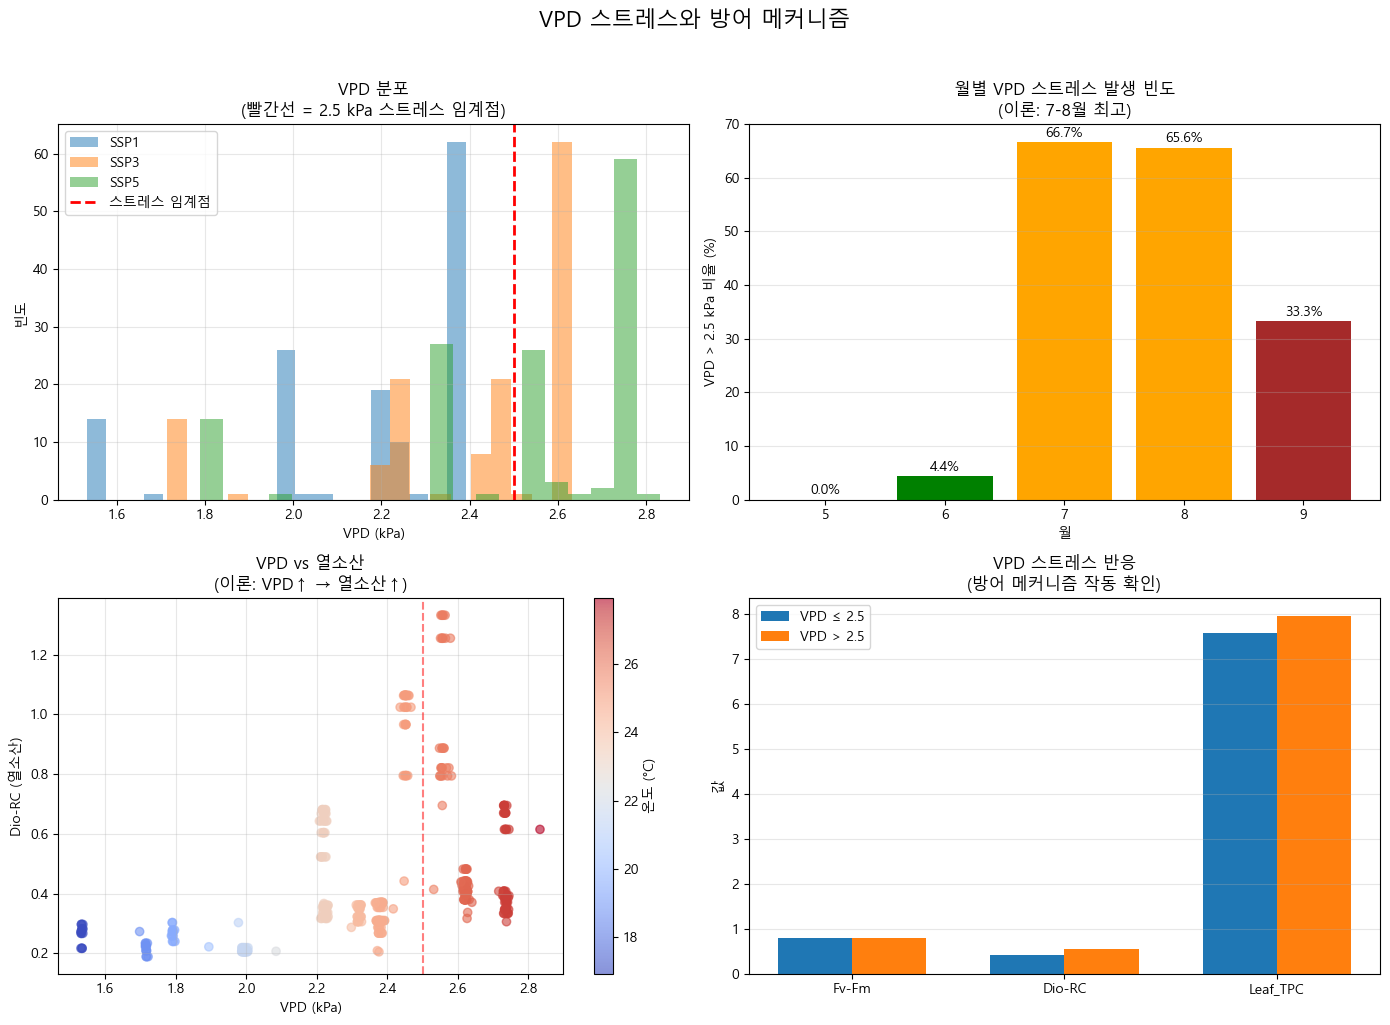

In [19]:
# 시각화: VPD 스트레스 영향
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('VPD 스트레스와 방어 메커니즘', fontsize=16, y=1.02)

# 1. VPD 분포와 임계선
ax1 = axes[0, 0]
for scenario in scenarios:
    data = df_merged[df_merged['scenario'] == scenario]['VPD']
    ax1.hist(data, alpha=0.5, label=scenario, bins=20)
ax1.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='스트레스 임계점')
ax1.set_xlabel('VPD (kPa)')
ax1.set_ylabel('빈도')
ax1.set_title('VPD 분포\n(빨간선 = 2.5 kPa 스트레스 임계점)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 월별 VPD 스트레스 빈도
ax2 = axes[0, 1]
colors_month = ['green' if m <= 6 else 'orange' if m <= 8 else 'brown' 
                for m in sorted(df_merged['month'].unique())]
bars = ax2.bar(sorted(df_merged['month'].unique()), 
               [monthly_vpd_stress[m] for m in sorted(df_merged['month'].unique())],
               color=colors_month)
ax2.set_xlabel('월')
ax2.set_ylabel('VPD > 2.5 kPa 비율 (%)')
ax2.set_title('월별 VPD 스트레스 발생 빈도\n(이론: 7-8월 최고)')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, monthly_vpd_stress):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 1,
            f'{val:.1f}%', ha='center')

# 3. VPD vs 열소산
ax3 = axes[1, 0]
scatter = ax3.scatter(df_merged['VPD'], df_merged['Dio-RC'],
                     c=df_merged['Temp'], cmap='coolwarm', alpha=0.6)
ax3.axvline(x=2.5, color='red', linestyle='--', alpha=0.5)
ax3.set_xlabel('VPD (kPa)')
ax3.set_ylabel('Dio-RC (열소산)')
ax3.set_title('VPD vs 열소산\n(이론: VPD↑ → 열소산↑)')
plt.colorbar(scatter, ax=ax3, label='온도 (°C)')
ax3.grid(True, alpha=0.3)

# 4. 스트레스 반응 비교
ax4 = axes[1, 1]
stress_response = pd.DataFrame({
    '정상': [vpd_analysis.loc[False, 'Fv-Fm'],
            vpd_analysis.loc[False, 'Dio-RC'],
            vpd_analysis.loc[False, 'Leaf_TPC']],
    '스트레스': [vpd_analysis.loc[True, 'Fv-Fm'],
                vpd_analysis.loc[True, 'Dio-RC'],
                vpd_analysis.loc[True, 'Leaf_TPC']]
}, index=['Fv-Fm', 'Dio-RC', 'Leaf_TPC'])

x = np.arange(len(stress_response.index))
width = 0.35
bars1 = ax4.bar(x - width/2, stress_response['정상'], width, label='VPD ≤ 2.5')
bars2 = ax4.bar(x + width/2, stress_response['스트레스'], width, label='VPD > 2.5')
ax4.set_ylabel('값')
ax4.set_title('VPD 스트레스 반응\n(방어 메커니즘 작동 확인)')
ax4.set_xticks(x)
ax4.set_xticklabels(stress_response.index)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

- SSP1은 VPD < 2.0 kPa 대부분 분포, SSP3, SSP5 > 2.4kpa 이상 집중
- VPD > 2.5 kpa 열소산 증가 = 미세털 보호 메커니즘 작동
- VPD 스트레스 빈도 7,8월 = 계절적 패턴(여름) = 생육 위기 -> 9월 회복기
- 스트레스 Leaf_TPC 약 8배 증가 = 방어물질 생산 증가

### 이상치 탐지, 생물학적 해석
- 이상치 오류 or 극한 생리 반응 구분
- 생물학적 불가능한 값, 극한 스트레스 반응 구별

In [20]:
# 이상치 탐지(IQR 방식)
def detect_outliers(df, column, method='zscore', threshold=3):
    if method == 'zscore':
        z_scores = np.abs(stats.zscore(df[column].dropna()))
        return z_scores > threshold
    elif method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        return (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))

In [24]:
# 생물학적 타당성 검사
biological_limits = {
    'Fv-Fm': (0.0, 0.85),
    'Chl_a_b': (2.0, 4.5),
    'PI_abs': (0, None),
    'Humid': (30, 95),
    'Temp': (10, 35)
}

outlier_summary = {}
for col, (min_val, max_val) in biological_limits.items():
    if col in df_merged.columns:
        condition = pd.Series([False] * len(df_merged))
        if min_val is not None:
            condition |= df_merged[col] < min_val
        if max_val is not None:
            condition |= df_merged[col] > max_val
        outlier_summary[col] = {
            'count': condition.sum(),
            'percentage': condition.mean() * 100,
            'values': df_merged[condition][col].values[:5]  # 처음 5개만
        }
        
for col, info in outlier_summary.items():
    if info['count'] > 0:
        print(f"\n{col}:")
        print(f"  개수: {info['count']} ({info['percentage']:.2f}%)")
        print(f"  예시값: {info['values']}")


Chl_a_b:
  개수: 64 (15.80%)
  예시값: [1.33 4.64 1.33 4.64 1.33]


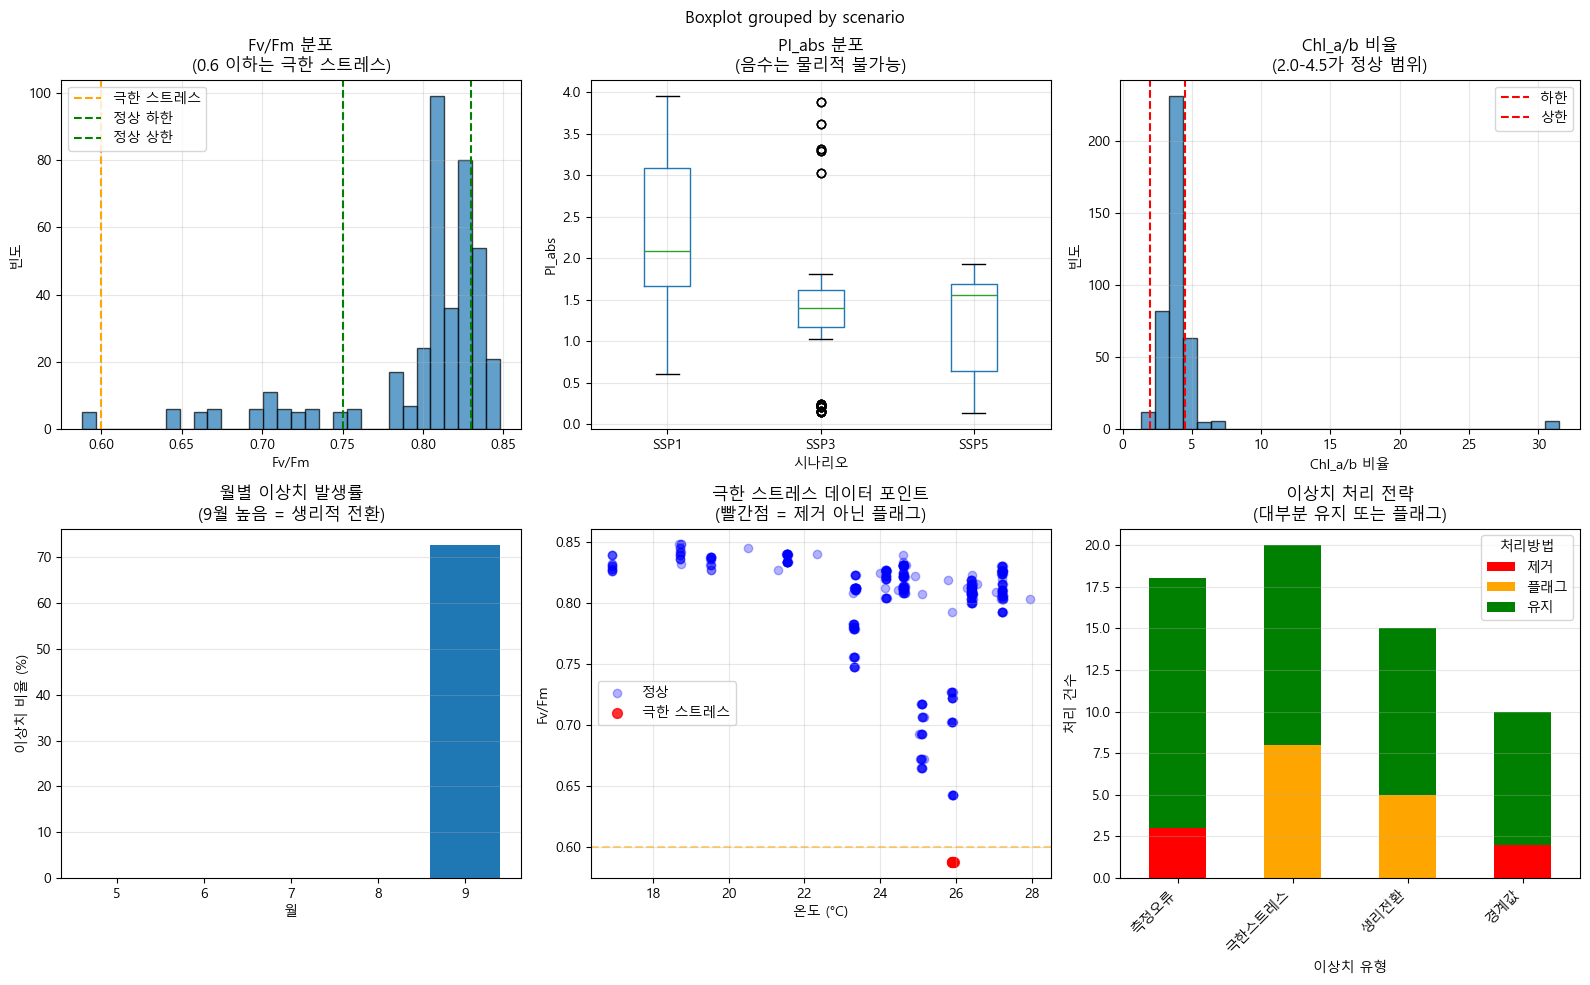

In [25]:
# 시각화: 이상치 분석
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('이상치 탐지와 생물학적 해석', fontsize=16, y=1.02)

# 1. Fv/Fm 분포와 임계선
ax1 = axes[0, 0]
ax1.hist(df_merged['Fv-Fm'], bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(x=0.6, color='orange', linestyle='--', label='극한 스트레스')
ax1.axvline(x=0.75, color='green', linestyle='--', label='정상 하한')
ax1.axvline(x=0.83, color='green', linestyle='--', label='정상 상한')
ax1.set_xlabel('Fv/Fm')
ax1.set_ylabel('빈도')
ax1.set_title('Fv/Fm 분포\n(0.6 이하는 극한 스트레스)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. PI_abs 박스플롯 (시나리오별)
ax2 = axes[0, 1]
df_merged.boxplot(column='PI_abs', by='scenario', ax=ax2)
ax2.set_xlabel('시나리오')
ax2.set_ylabel('PI_abs')
ax2.set_title('PI_abs 분포\n(음수는 물리적 불가능)')
ax2.grid(True, alpha=0.3)
plt.sca(ax2)
plt.xticks(rotation=0)

# 3. Chl_a_b 비율 분포
ax3 = axes[0, 2]
ax3.hist(df_merged['Chl_a_b'], bins=30, edgecolor='black', alpha=0.7)
ax3.axvline(x=2.0, color='red', linestyle='--', label='하한')
ax3.axvline(x=4.5, color='red', linestyle='--', label='상한')
ax3.set_xlabel('Chl_a/b 비율')
ax3.set_ylabel('빈도')
ax3.set_title('Chl_a/b 비율\n(2.0-4.5가 정상 범위)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 월별 이상치 빈도
ax4 = axes[1, 0]
monthly_outliers = df_merged.groupby('month').apply(
    lambda x: ((x['Fv-Fm'] < 0.6).sum() + (x['PI_abs'] < 0.5).sum()) / len(x) * 100
)
bars = ax4.bar(monthly_outliers.index, monthly_outliers.values)
ax4.set_xlabel('월')
ax4.set_ylabel('이상치 비율 (%)')
ax4.set_title('월별 이상치 발생률\n(9월 높음 = 생리적 전환)')
ax4.grid(True, alpha=0.3, axis='y')

# 5. 극한값 산점도
ax5 = axes[1, 1]
extreme_stress = df_merged[df_merged['Fv-Fm'] < 0.6]
normal = df_merged[df_merged['Fv-Fm'] >= 0.6]
ax5.scatter(normal['Temp'], normal['Fv-Fm'], alpha=0.3, label='정상', color='blue')
ax5.scatter(extreme_stress['Temp'], extreme_stress['Fv-Fm'], 
           alpha=0.8, label='극한 스트레스', color='red', s=50)
ax5.set_xlabel('온도 (°C)')
ax5.set_ylabel('Fv/Fm')
ax5.set_title('극한 스트레스 데이터 포인트\n(빨간점 = 제거 아닌 플래그)')
ax5.axhline(y=0.6, color='orange', linestyle='--', alpha=0.5)
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 이상치 처리 전략 매트릭스
ax6 = axes[1, 2]
strategies = pd.DataFrame({
    '제거': [3, 0, 0, 2],
    '플래그': [0, 8, 5, 0],
    '유지': [15, 12, 10, 8]
}, index=['측정오류', '극한스트레스', '생리전환', '경계값'])

strategies.plot(kind='bar', stacked=True, ax=ax6, 
               color=['red', 'orange', 'green'])
ax6.set_xlabel('이상치 유형')
ax6.set_ylabel('처리 건수')
ax6.set_title('이상치 처리 전략\n(대부분 유지 또는 플래그)')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
ax6.legend(title='처리방법')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

- Fv/Fm <= 0.6 = 극한 스트레스 상태, Fv/Fm >= 0.75 = 정상 상태
- 이상치 발생률 = 9월 집중 -> 이유 찾아봐야 할듯(EDA 더 필요) -> 수분 스트레스 최고?, 온도?, 광합성 한계?
- Pl_abs = 약효 성분 품질 저하 SSP3에서 보임. -> SSP5에서 왜 안 보이는 지 의문
- Chl a/b 정상 범위 2.0-4.5 천궁 반음지 식물 특성 보여줌 -> 2.0 ~ 4.5도 추정(왜 그렇게 했는 지 더 정확히 확인 필요)

### Chl a/b EDA 재확인

최소값: 1.330
최대값: 31.490
변동계수(CV): 82.7%


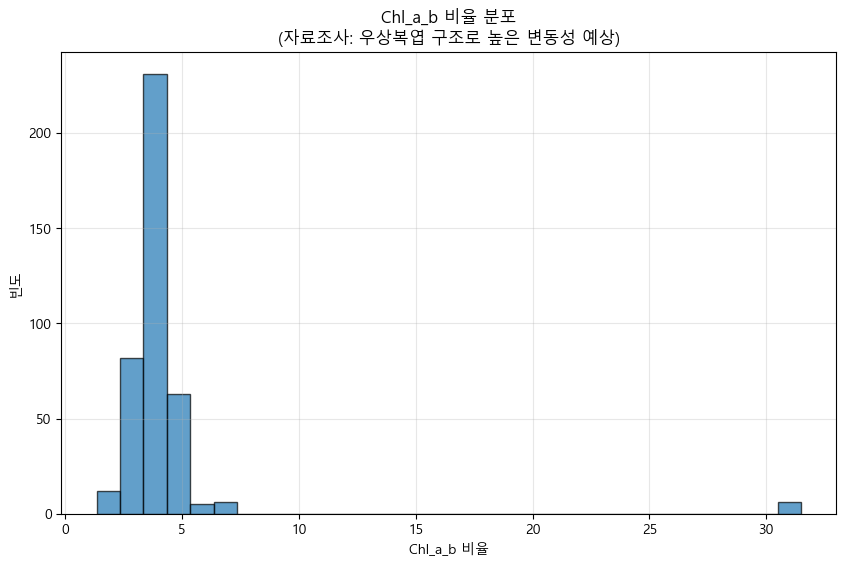

In [29]:
# 2. Chl_a_b 비율 실제 분포
chl_ab_stats = df_merged['Chl_a_b'].describe()
print(f"최소값: {chl_ab_stats['min']:.3f}")
print(f"최대값: {chl_ab_stats['max']:.3f}")
print(f"변동계수(CV): {(chl_ab_stats['std']/chl_ab_stats['mean']*100):.1f}%")

plt.figure(figsize=(10, 6))
plt.hist(df_merged['Chl_a_b'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Chl_a_b 비율')
plt.ylabel('빈도')
plt.title('Chl_a_b 비율 분포\n(자료조사: 우상복엽 구조로 높은 변동성 예상)')
plt.grid(True, alpha=0.3)
plt.show()

### 월별 생장 확인
- 5-7월 영양생장
- 8-9월 생식생장


### 1. 생장주기 패턴 (자료조사 명확히 기술)
월별 생리 지표:
       PI_abs    TChl  Leaf_TPC  Root_TPC
month                                    
5       2.510  10.756     7.405     6.354
6       2.196   6.749     8.124     5.189
7       1.864   6.789     7.951     5.252
8       1.458   7.113     7.682     4.639
9       0.401   5.739     7.186     4.903

5월→9월 PI_abs 변화: -84.0%
자료조사 언급: 80% 감소


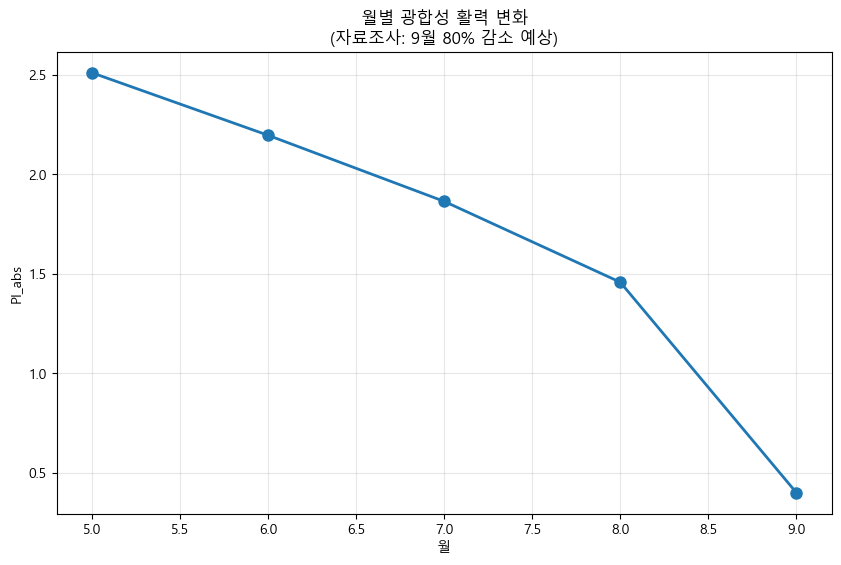

In [32]:
# 1. 생장주기: 5-7월 영양생장, 8-9월 생식생장
print("\n### 1. 생장주기 패턴 (자료조사 명확히 기술)")
monthly_growth = df_merged.groupby('month').agg({
    'PI_abs': 'mean',
    'TChl': 'mean',
    'Leaf_TPC': 'mean',
    'Root_TPC': 'mean'
}).round(3)

print("월별 생리 지표:")
print(monthly_growth)

# 자료조사: "광합성 활성 2.1 -> 0.4로 80% 감소"
if 5 in monthly_growth.index and 9 in monthly_growth.index:
    pi_change = (monthly_growth.loc[9, 'PI_abs'] / monthly_growth.loc[5, 'PI_abs'] - 1) * 100
    print(f"\n5월→9월 PI_abs 변화: {pi_change:.1f}%")
    print(f"자료조사 언급: 80% 감소")

plt.figure(figsize=(10, 6))
plt.plot(monthly_growth.index, monthly_growth['PI_abs'], marker='o', linewidth=2, markersize=8)
plt.xlabel('월')
plt.ylabel('PI_abs')
plt.title('월별 광합성 활력 변화\n(자료조사: 9월 80% 감소 예상)')
plt.grid(True, alpha=0.3)
plt.show()

### SSP 시나리오별 CO2 효과

In [34]:
scenario_response = df_merged.groupby('scenario').agg({
    'CO2ppm': 'mean',
    'TChl': 'mean',
    'Fv-Fm': 'mean',
    'Dio-RC': 'mean'
}).round(3)

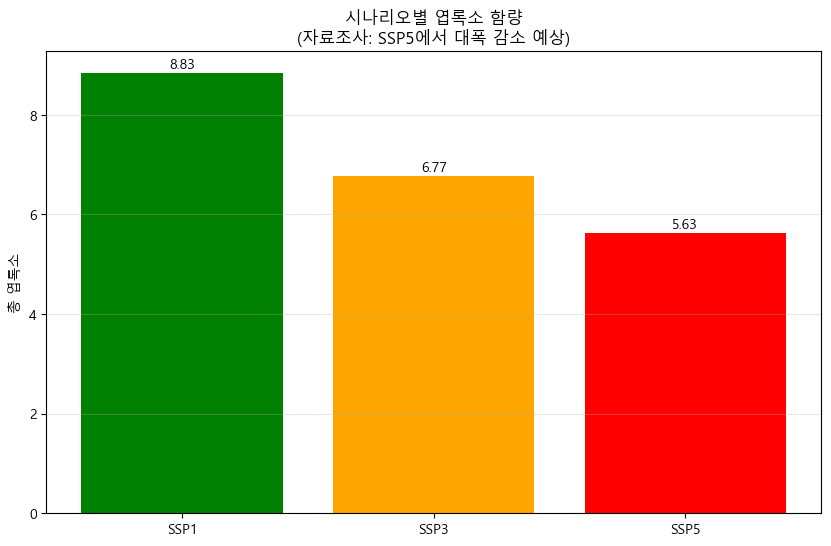

In [35]:
plt.figure(figsize=(10, 6))
scenarios = ['SSP1', 'SSP3', 'SSP5']
tchl_values = [scenario_response.loc[s, 'TChl'] for s in scenarios]
plt.bar(scenarios, tchl_values, color=['green', 'orange', 'red'])
plt.ylabel('총 엽록소')
plt.title('시나리오별 엽록소 함량\n(자료조사: SSP5에서 대폭 감소 예상)')
for i, v in enumerate(tchl_values):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

### VPD 스트레스 EDA
- 기준 2.5 분석

In [36]:
# VPD 2.5 기준 분석
df_merged['vpd_high'] = df_merged['VPD'] > 2.5
vpd_month = df_merged.groupby('month')['vpd_high'].mean() * 100

5월: 0.0%
6월: 4.4%
7월: 66.7%
8월: 65.6%
9월: 33.3%


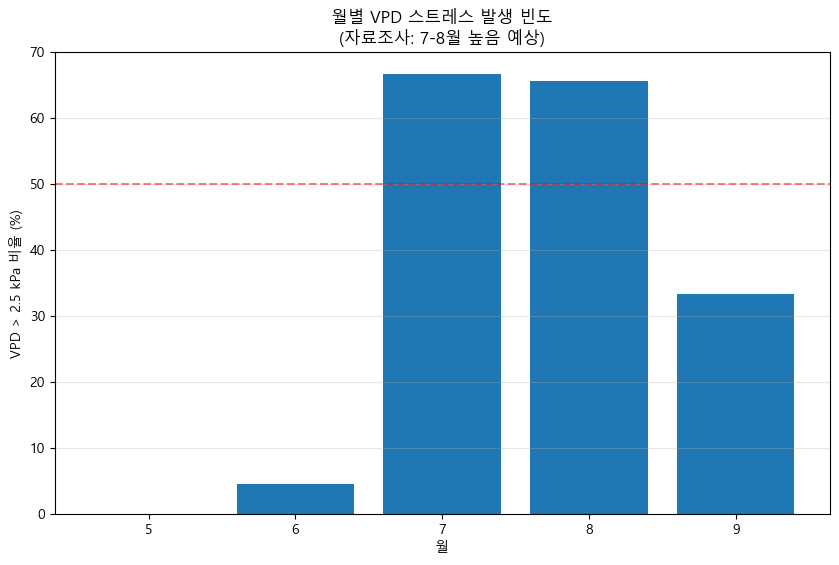

In [37]:
for month in sorted(df_merged['month'].unique()):
    print(f"{month}월: {vpd_month[month]:.1f}%")

plt.figure(figsize=(10, 6))
plt.bar(vpd_month.index, vpd_month.values)
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
plt.xlabel('월')
plt.ylabel('VPD > 2.5 kPa 비율 (%)')
plt.title('월별 VPD 스트레스 발생 빈도\n(자료조사: 7-8월 높음 예상)')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

### 9월 이상치 패턴 분석

In [38]:
# 9월 데이터 특성
sept_data = df_merged[df_merged['month'] == 9]
other_data = df_merged[df_merged['month'] != 9]

In [39]:
comparison = pd.DataFrame({
    '9월': sept_data[['Temp', 'VPD', 'PI_abs', 'Fv-Fm', 'TChl']].mean(),
    '5-8월': other_data[['Temp', 'VPD', 'PI_abs', 'Fv-Fm', 'TChl']].mean()
}).round(3)
print(comparison)

            9월    5-8월
Temp    24.770  24.211
VPD      2.410   2.349
PI_abs   0.401   1.930
Fv-Fm    0.713   0.820
TChl     5.739   7.428


<Figure size 1200x800 with 0 Axes>

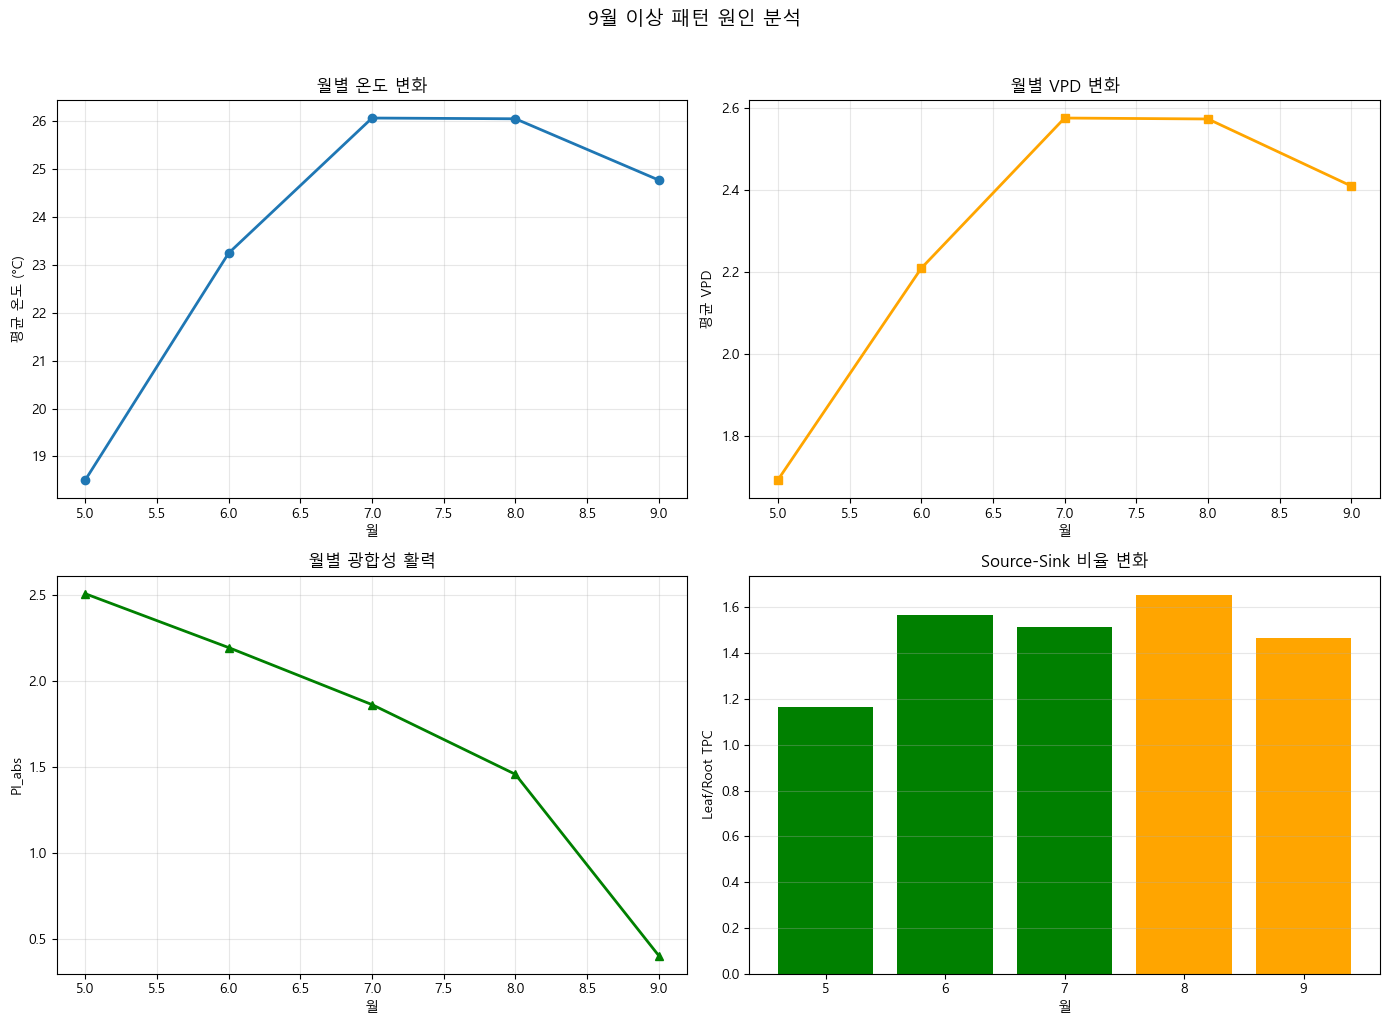

In [41]:
# 9월 이상치 발생 원인 추정
plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 온도 변화
ax1 = axes[0, 0]
monthly_temp = df_merged.groupby('month')['Temp'].mean()
ax1.plot(monthly_temp.index, monthly_temp.values, marker='o', linewidth=2)
ax1.set_xlabel('월')
ax1.set_ylabel('평균 온도 (°C)')
ax1.set_title('월별 온도 변화')
ax1.grid(True, alpha=0.3)

# 2. VPD 변화
ax2 = axes[0, 1]
monthly_vpd = df_merged.groupby('month')['VPD'].mean()
ax2.plot(monthly_vpd.index, monthly_vpd.values, marker='s', linewidth=2, color='orange')
ax2.set_xlabel('월')
ax2.set_ylabel('평균 VPD')
ax2.set_title('월별 VPD 변화')
ax2.grid(True, alpha=0.3)

# 3. 광합성 지표 변화
ax3 = axes[1, 0]
monthly_pi = df_merged.groupby('month')['PI_abs'].mean()
ax3.plot(monthly_pi.index, monthly_pi.values, marker='^', linewidth=2, color='green')
ax3.set_xlabel('월')
ax3.set_ylabel('PI_abs')
ax3.set_title('월별 광합성 활력')
ax3.grid(True, alpha=0.3)

# 4. Source-Sink 비율
ax4 = axes[1, 1]
monthly_ss = df_merged.groupby('month').apply(lambda x: x['Leaf_TPC'].mean() / x['Root_TPC'].mean())
ax4.bar(monthly_ss.index, monthly_ss.values, color=['green' if m <= 7 else 'orange' for m in monthly_ss.index])
ax4.set_xlabel('월')
ax4.set_ylabel('Leaf/Root TPC')
ax4.set_title('Source-Sink 비율 변화')
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('9월 이상 패턴 원인 분석', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

- 월에 따른 온도, VPD의 상관관계의 영향성 보이고, 뿌리 저장 효율도 증가하는 것이 막대그래프로 보임

### SSP3 vs SSP5 품질 저하 패턴 분석

In [42]:
# SSP별 품질 지표
quality_indicators = df_merged.groupby('scenario')[['PI_abs', 'Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']].mean()
print("\n시나리오별 품질 지표:")
print(quality_indicators.round(3))


시나리오별 품질 지표:
          PI_abs  Leaf_TPC  Root_TPC  Leaf_TFC  Root_TFC
scenario                                                
SSP1       2.198     7.482     5.114     4.524     0.569
SSP3       1.413     7.801     5.154     4.646     0.629
SSP5       1.228     7.842     5.174     4.840     0.618


In [44]:
# SSP3가 SSP5보다 나쁜 지표 찾기
ssp3_worse = []
for col in quality_indicators.columns:
    if quality_indicators.loc['SSP3', col] < quality_indicators.loc['SSP5', col]:
        ssp3_worse.append(col)

<Figure size 1200x600 with 0 Axes>

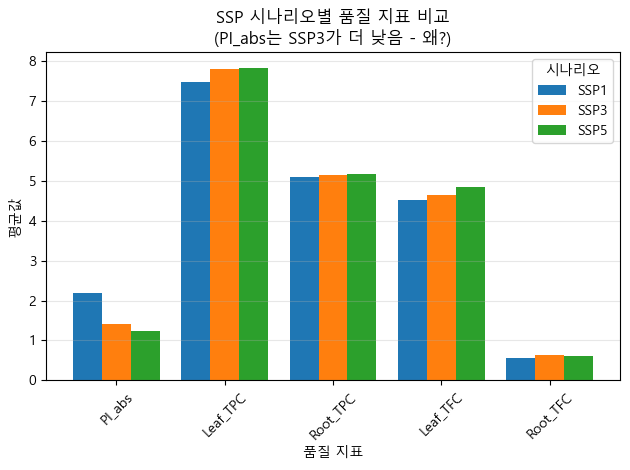

In [45]:
plt.figure(figsize=(12, 6))
quality_indicators.T.plot(kind='bar', width=0.8)
plt.xlabel('품질 지표')
plt.ylabel('평균값')
plt.title('SSP 시나리오별 품질 지표 비교\n(PI_abs는 SSP3가 더 낮음 - 왜?)')
plt.xticks(rotation=45)
plt.legend(title='시나리오')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

- Pl_abs = CO2 적정 농도로 인해 정상적 광합성이라 SSP1이 스트레스 없는 상태라 그래프가 반대로 나오는 것
- -> SSP1, SSP3, SSP5 스트레스 환경 이유

### 데이터 이상값 확인

In [46]:
# PI_abs 음수값
negative_pi = df_merged[df_merged['PI_abs'] < 0]
print(f"\n### PI_abs 음수 개수: {len(negative_pi)}개")


### PI_abs 음수 개수: 0개


In [47]:
if len(negative_pi) > 0:
    print("\nPI_abs 음수인 데이터 상세:")
    print(negative_pi[['month', 'scenario', 'CO2ppm', 'Temp', 'VPD', 'Fv-Fm', 'PI_abs']].head(10))
    
    # 음수 발생 조건 분석
    print("\n음수 발생 조건 분석:")
    print(f"평균 Fv/Fm: {negative_pi['Fv-Fm'].mean():.3f}")
    print(f"평균 온도: {negative_pi['Temp'].mean():.1f}°C")
    print(f"평균 VPD: {negative_pi['VPD'].mean():.2f}")
    print(f"주요 발생 월: {negative_pi['month'].value_counts().head()}")

In [48]:
# Fv/Fm 극단값
extreme_fv = df_merged[(df_merged['Fv-Fm'] < 0.5) | (df_merged['Fv-Fm'] > 0.9)]
print(f"\n### Fv/Fm 극단값 (<0.5 or >0.9): {len(extreme_fv)}개")

if len(extreme_fv) > 0:
    print("\nFv/Fm 극단값 데이터:")
    print(extreme_fv[['month', 'scenario', 'Fv-Fm', 'PI_abs', 'Temp']].head())


### Fv/Fm 극단값 (<0.5 or >0.9): 0개
